# Sourcing & Analyzing Time-Series Data
Practice with using Quandl and pulling data from Nasdaq.com

Performing tasks for CareerFoundry's Sourcing & Analyzing Time Series Data project.  This will include work with determining stationarity and possibly correcting data from non-stationary to stationary.  Tasks addressed for this project include:

#### -Utilizing API key.

#### -Plotting Data.

#### -Cleaning & Wrangling Data.

#### -Decomposing data to separate Trend, Seasonality, and Noise.

#### -Testing for Stationarity via Dickey_Fuller tests.

#### -Determining Autocorrelation.

#### -Differencing data to achieve Stationarity.

## Importing Libraries and Data

In [1]:
# Importing typical libraries.  Warning filter is to bypass deprecated notices.
# fivethirtyeight style will be used for plots.
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Configure API key.
quandl.ApiConfig.api_key = 'Bv6BP27iCk-zuywF7SbH'

In [7]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.
data = quandl.get('FRED/PCE')

### Testing The Data

In [8]:
# Testing it to make sure all went well
data.head()

,Value
Date,
1959-01-01,306.1
1959-02-01,309.6
1959-03-01,312.7
1959-04-01,312.2
1959-05-01,316.1


In [9]:
data.shape

(756, 1)

In [10]:
data.columns

Index(['Value'], dtype='object')

In [11]:
type(data)

pandas.core.frame.DataFrame

In [13]:
# Checking for null values.
data.isnull().sum()

Value    0
dtype: int64

In [15]:
# Checking for duplicate data
dups = data.duplicated()
dups.sum()

2

#### Insight:
There are two duplicate values but, that honestly doesn't seem too bad? Going to move forward with it in place and if charts are odd, then I will drop those values.

## Drawing Line Graph

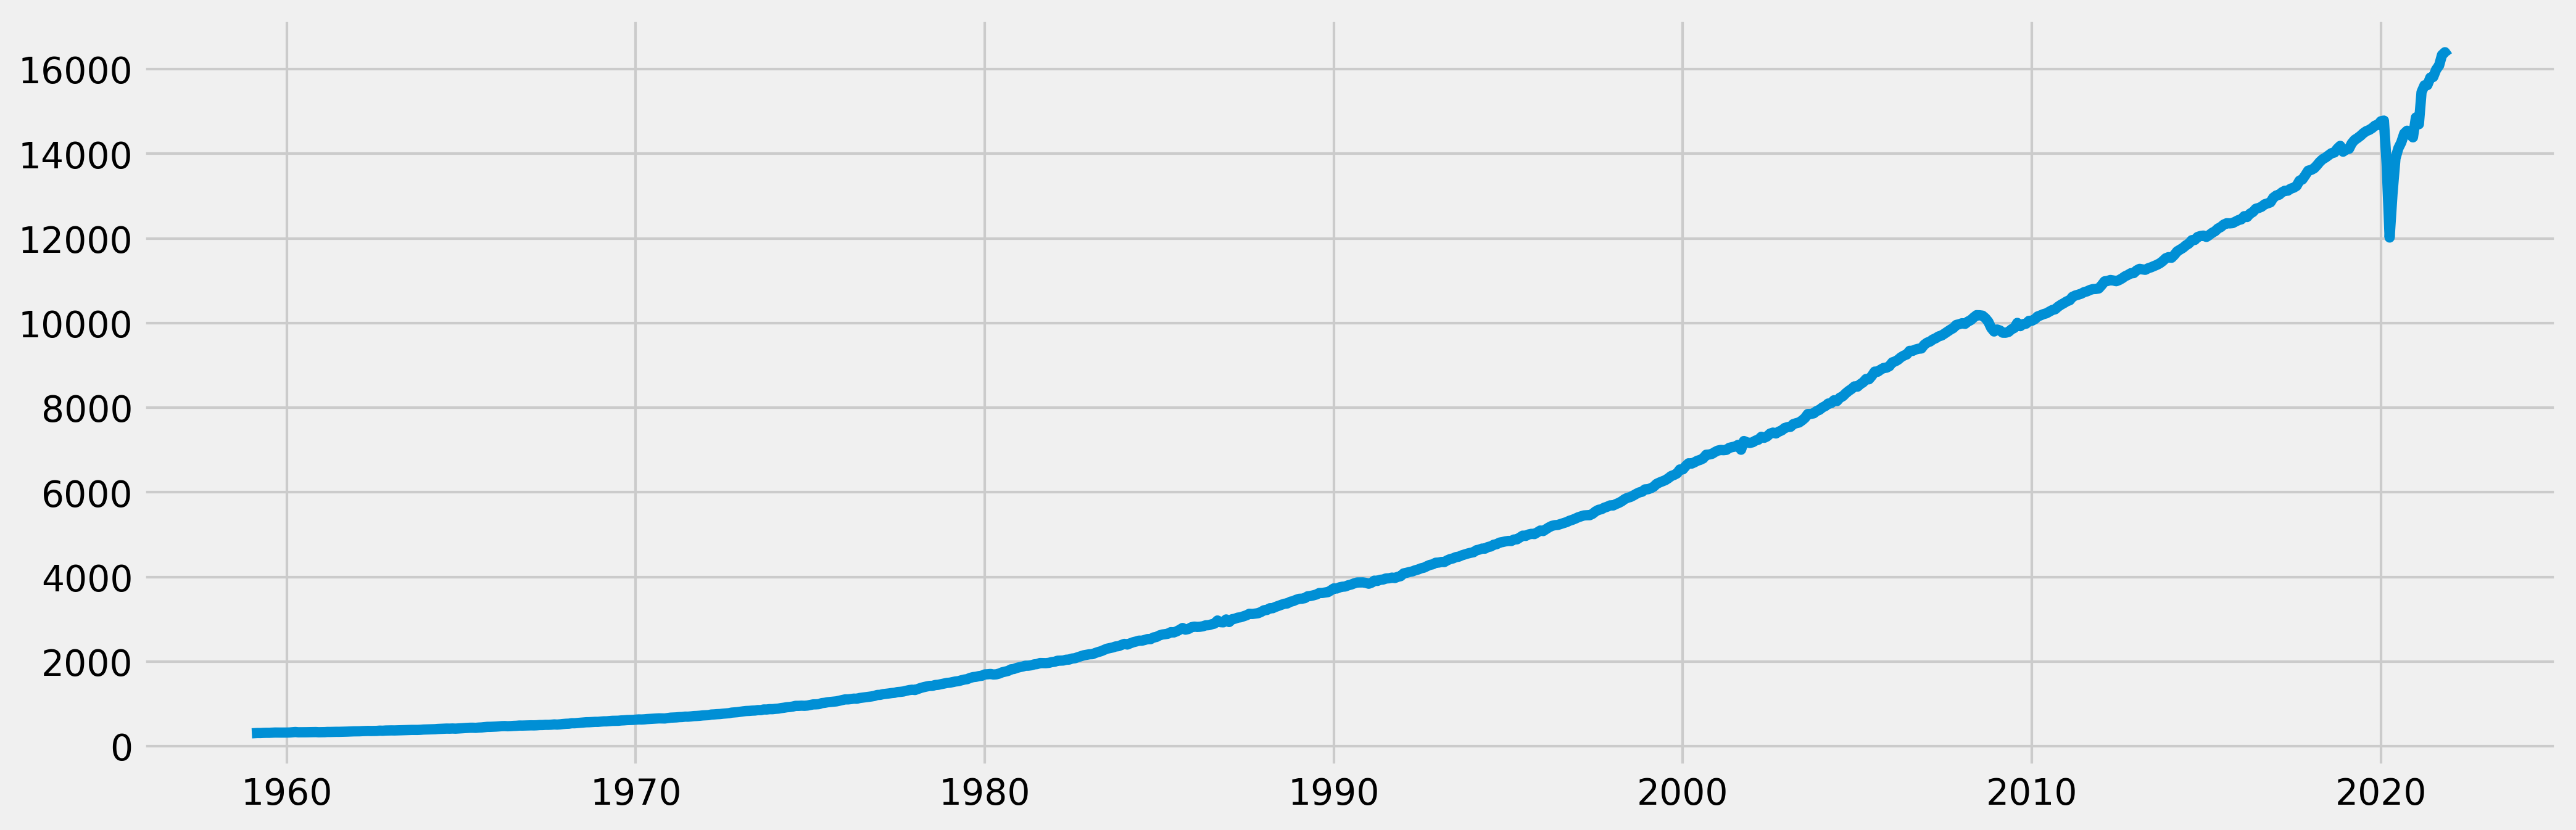

In [12]:
# Plotting the data
plt.figure(figsize=(15,5), dpi=300)
plt.plot(data)

#### Insight:
I was tempted to create a subset of data prior to 2020, due to Covid19.  However, I am curiou sto see how the years after 2020 correlated after the sharp drop.  Additionally, I am curious to see if the cleaning techniques for finding stationarity will be able to look past that - so I will keep the data as is for now.

Of note, the data is clearly trending up, so that will almost guarantee its non-stationary.  However, we will see if that is not the case as we go through the exercise.

## Decomposing Data

In [24]:
# Decomposing the time series using an additive model - it looks linear enough?
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [26]:
# Importing library and function to define fixed size for special charts
from pylab import rcParams
rcParams['figure.figsize']=18,7

<function matplotlib.pyplot.show(close=None, block=None)>

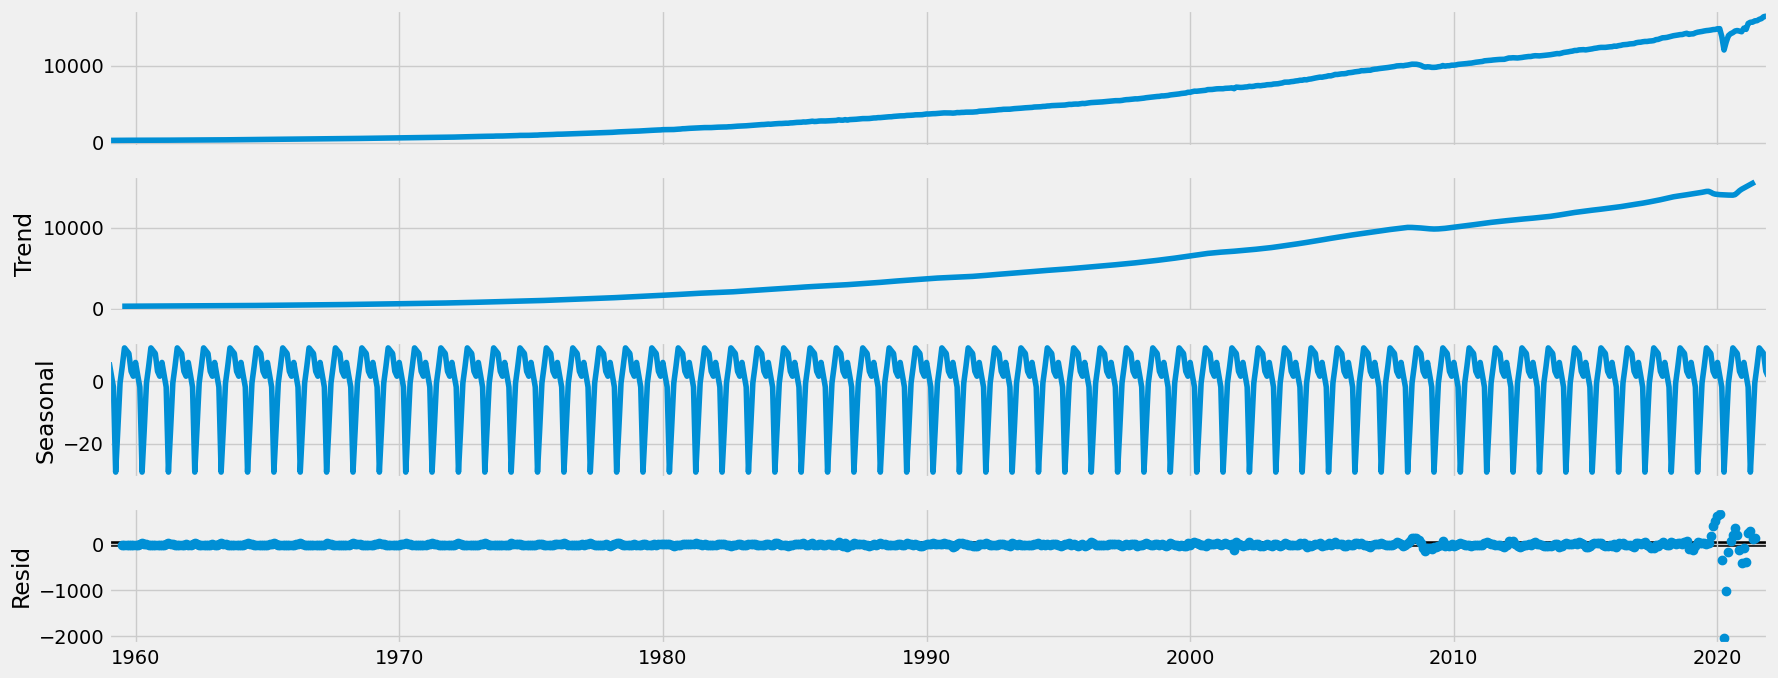

In [27]:
# Plotting the decomposition data
decomposition.plot()
plt.show

#### Insight:
The level looks VERY similar to the trend.  This implies that the dataset we are working with is smooth, so noise shouldn't be too much of a concern.  As we expected, noise was more pronounced for 2020 due to Covid19.

We have some seasonality, as the curve is not flat at all.

## Conducting Dickey-Fuller Testing

In [28]:
# Adding function for adfuller to get a statistical model for testing
from statsmodels.tsa.stattools import adfuller

# Defining the function to label the output from adfuller
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   5.738592
p-value                          1.000000
Number of Lags Used             20.000000
Number of Observations Used    735.000000
Critical Value (1%)             -3.439278
Critical Value (5%)             -2.865480
Critical Value (10%)            -2.568868
dtype: float64


#### Insight:
Well... the goal was a p-value of 0.05, got 1.00... so that's not good.  The test statistic of 5.7 is also quite a bit larger than -2.865 for a critical value of 5%.  Overall, expected due to the visible trend but... much larger values than anticipated.

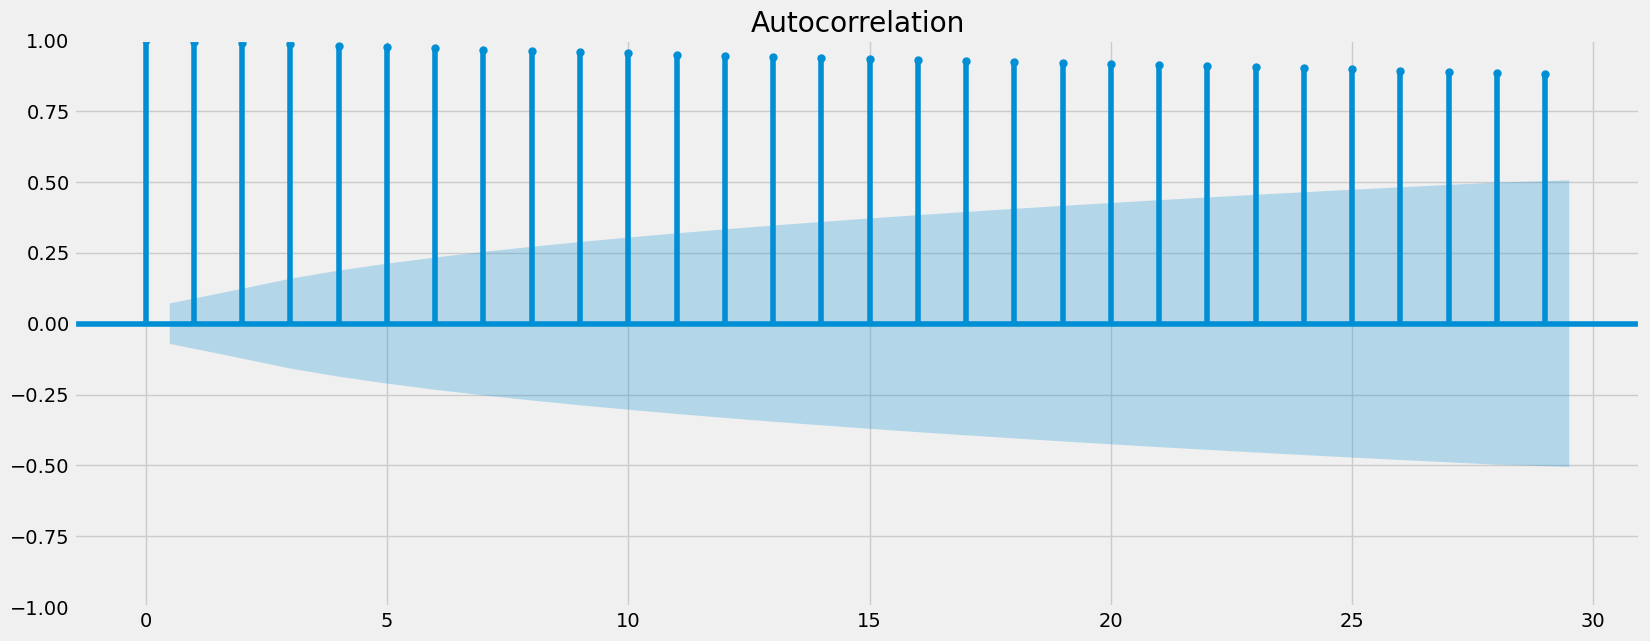

In [29]:
# Checking the autocorrelation, expecting a lot of values above the line
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plt.show()

## Stationarizing the Data

In [31]:
# Performing differencing in attempt to stationarize data
data_2 = data - data.shift(1)

In [32]:
# Dropping null values in case
data_2.dropna(inplace = True)

In [33]:
data_2.head()

,Value
Date,
1959-02-01,3.5
1959-03-01,3.1
1959-04-01,-0.5
1959-05-01,3.9
1959-06-01,2.1


In [34]:
data_2.columns

Index(['Value'], dtype='object')

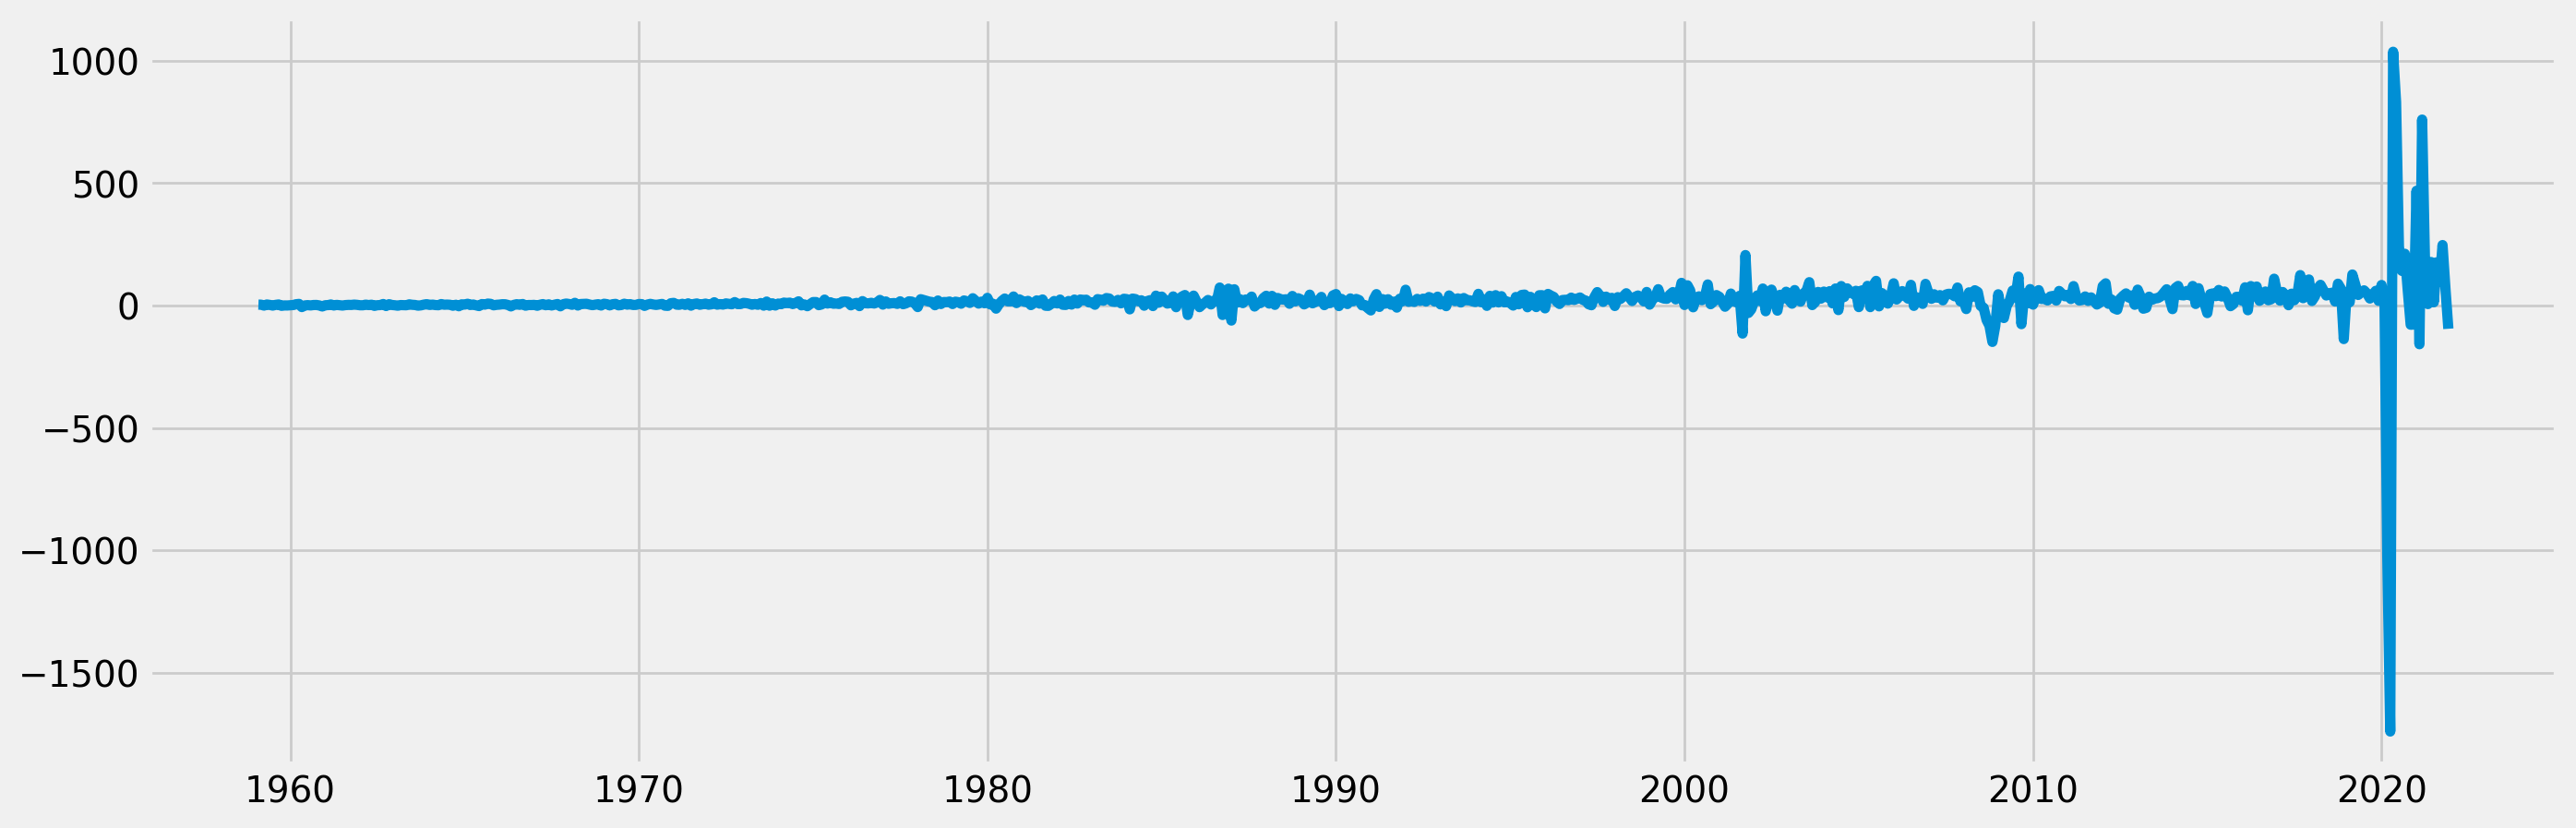

In [36]:
# Seeing if the plot looks different after that
plt.figure(figsize=(15,5), dpi=200)
plt.plot(data_2)

#### Insight
The upward trend is now corrected but it is more clear that the 2020 data was truly an outlier and really skewed / influenced the dataset.  Additionally, we can see a very heavy attempt to course correct for each quarter of 2020 and beyond.

In [38]:
dickey_fuller(data_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.757722
p-value                          0.003371
Number of Lags Used             18.000000
Number of Observations Used    736.000000
Critical Value (1%)             -3.439266
Critical Value (5%)             -2.865475
Critical Value (10%)            -2.568865
dtype: float64


#### Insight:
Test statistic is now -3.76, p-value is below what we were aiming for, 0.05 so that is good.  Test Statistic is a lower value than critical value (5%) as well, looks like we were successful after one attempt at stationarizing!

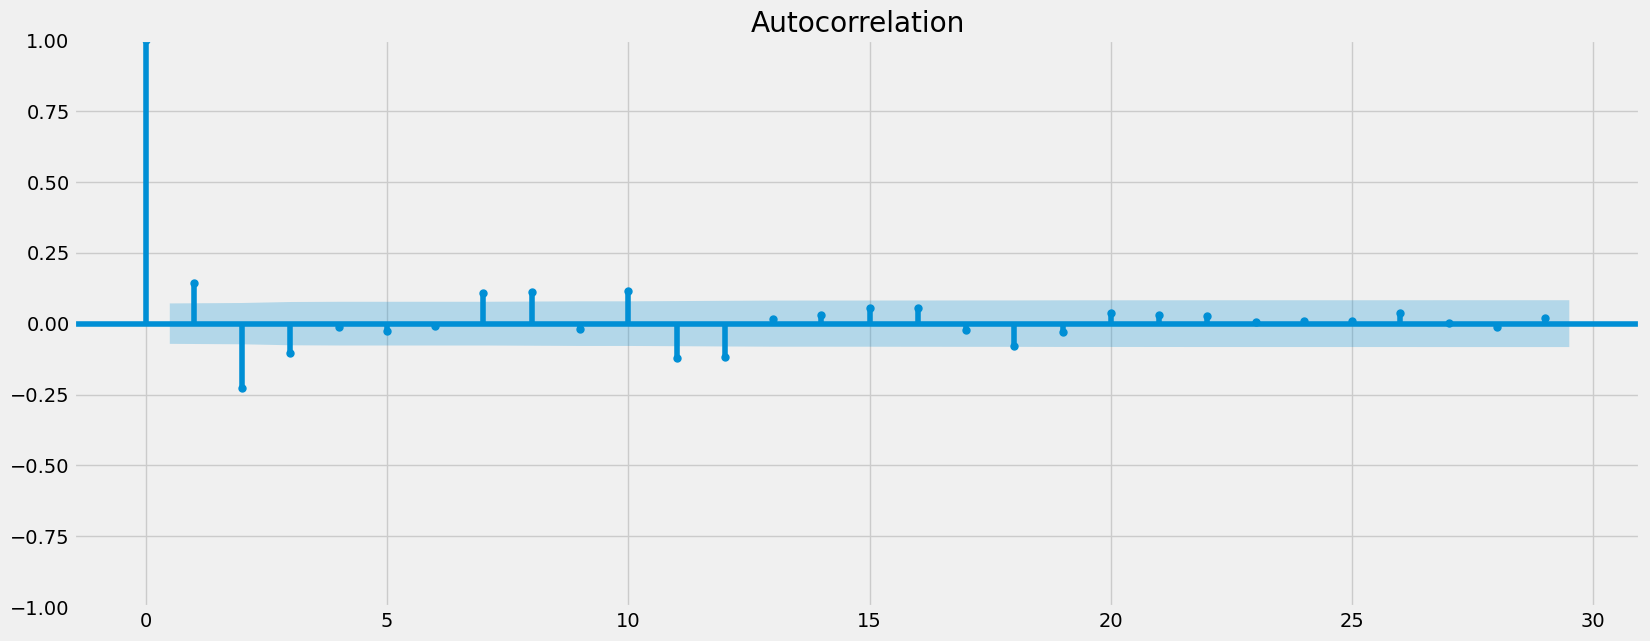

In [39]:
# Very curious to see how the autocorrelation looks now
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_2)
plt.show()